# Predict Bike Trip Duration In BigQuery ML

In order to build a system to properly stock bicycles, we need to predict the duration of bicycle rentals.

### 1. Connecting BigQuery Jupyter Notebook

Set environment variables for notebook to connect Bigquery

In [1]:
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/Rakyan Prajnagra/Documents/Data Engineer/GCP-DataEngineerLearningPath/Quest-MachineLearning/Quest-2-Predict-Bike-Trip-Duration/qwiklabs-gcp-03-3dd43bc72a0c-0d544affad01.json'

Load the BigQuery client library by executing the command below

In [2]:
%load_ext google.cloud.bigquery

### 2. Explore Bike Data

The objective of our Machine Learning is to predict the duration of a rental based on historical dataset of cycle rentals. The first step is to formulate a model. The most important part of building accurate Machine Learning model is a feature engineering (identify feature and label).

To identify the feature and label, we have to understand the data first. Check whether the information of the features we used are correlated with the label.

#### A. The Relationship of The Station and Trip Duration

To find out the difference of trip duration in each station

In [3]:
%%bigquery station
SELECT
  start_station_name,
  AVG(duration) AS duration
FROM `bigquery-public-data`.london_bicycles.cycle_hire
GROUP BY start_station_name

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='start_station_name'>

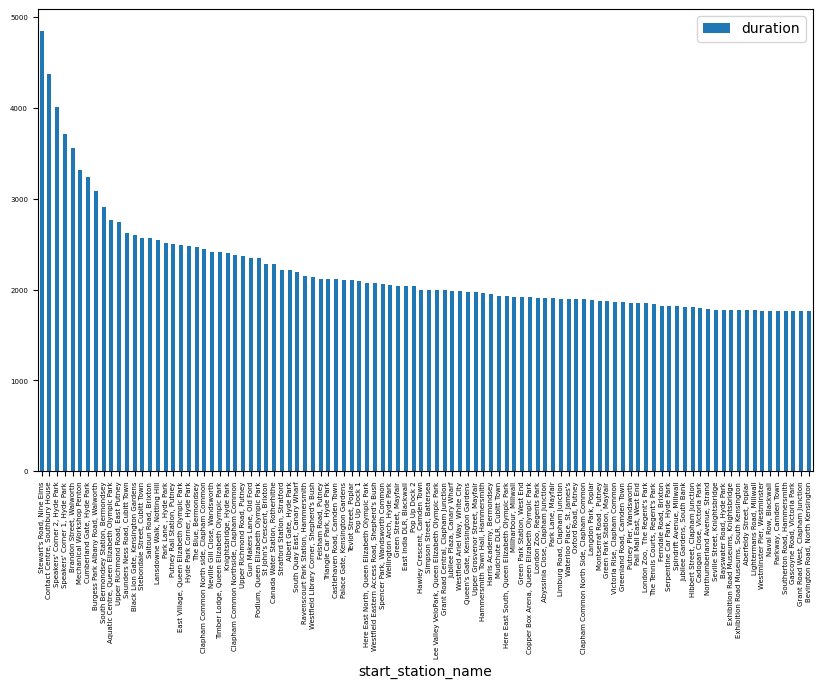

In [11]:
import pandas as pd
sort_station = station.sort_values(by='duration', ascending=False)
index_station = sort_station.reset_index(drop=True)
station_bar = index_station.iloc[0:100]
station_bar.plot.bar(x='start_station_name', figsize=(10,6), fontsize=5)

From the chart above, some stations are associated with long-duration rentals (over than 1 hour trip), however most of the stations have a relatively narrow duration. 

We can use start_station_name as a feature because we know where the trip begin and how long the trip duration to the destination.

#### B. The Relationship of The Day and Trip Duration

Check whether the duration of a trip duration varies by day

In [20]:
%%bigquery day
SELECT
  EXTRACT(dayofweek FROM start_date) AS dayofweek,
  AVG(duration) AS duration
FROM `bigquery-public-data`.london_bicycles.cycle_hire
GROUP BY dayofweek

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='dayofweek'>

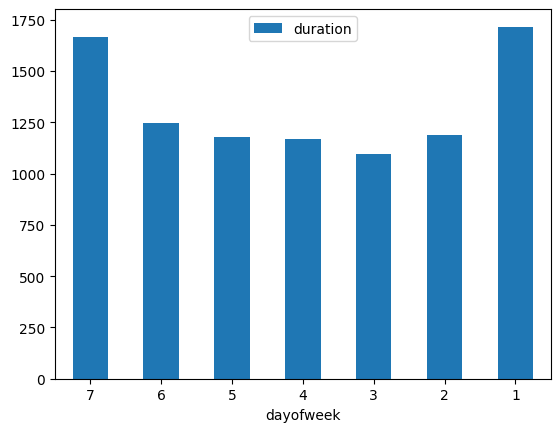

In [21]:
sort_day = day.sort_values(by='dayofweek', ascending=False)
sort_day.plot.bar(x='dayofweek', rot=0)

It appears that trip durations are longer on weekends (1 = Sunday & 7 = Saturday) than on the weekdays.

#### C. The Relationship of The Hour and Trip Duration

Check whether the duration of a trip duration varies by hour of day

In [22]:
%%bigquery hour
SELECT
  EXTRACT(hour FROM start_date) AS hourofday,
  AVG(duration) AS duration
FROM `bigquery-public-data`.london_bicycles.cycle_hire
GROUP BY hourofday

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='hourofday'>

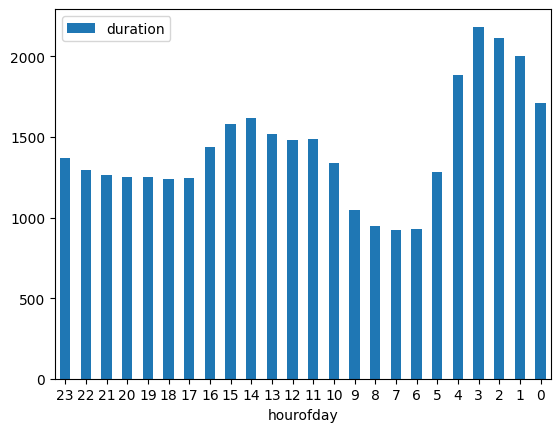

In [23]:
sort_hour = hour.sort_values(by='hourofday', ascending=False)
sort_hour.plot.bar(x='hourofday', rot=0)

It appears that trip durations are longer in the morning and afternoon.

Both day of week and hour of day are good features.

#### B. The Relationship of The Number Bicycles and Trip Duration

Another potential feature is the number of bikes in every stations.

In [24]:
%%bigquery bike
SELECT
  bikes_count,
  AVG(duration) AS duration
FROM `bigquery-public-data`.london_bicycles.cycle_hire
JOIN `bigquery-public-data`.london_bicycles.cycle_stations
ON cycle_hire.start_station_name = cycle_stations.name
GROUP BY bikes_count

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: xlabel='bikes_count'>

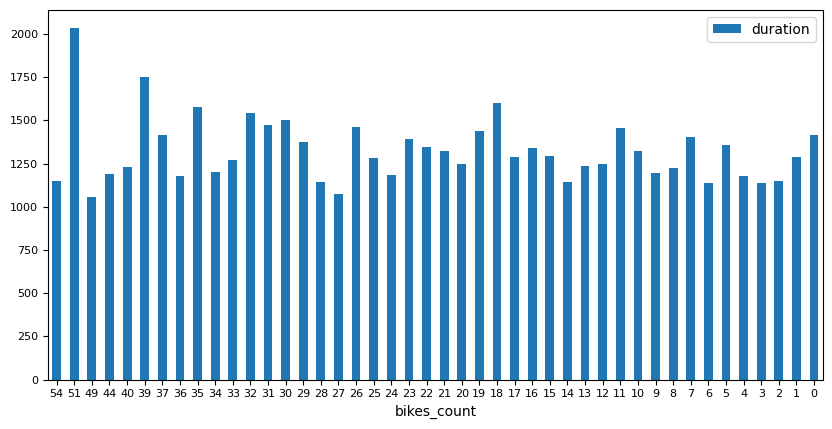

In [28]:
sort_bike = bike.sort_values(by='bikes_count', ascending=False)
sort_bike.plot.bar(x='bikes_count', figsize=(10,4.8), fontsize=8, rot=0)

From the result, we indicate the number of bicycle is not good feature because there is no visible trend.

### 3. Create a Model

In the process of building a model, we have to prepare the training dataset. From our exploration before, we select the feature and the label.

In [20]:
%%bigquery
SELECT
  duration,
  start_station_name,
  CAST(EXTRACT(dayofweek FROM start_date) AS STRING) AS dayofweek,
  CAST(EXTRACT(hour FROM start_date) AS STRING) AS hourofday
FROM `bigquery-public-data`.london_bicycles.cycle_hire
LIMIT 100

Query is running:   0%|          |

Downloading:   0%|          |

,duration,start_station_name,dayofweek,hourofday
0,3840,"Albert Gate, Hyde Park",4,19
1,3840,"Albert Gate, Hyde Park",4,14
2,3840,"Chepstow Villas, Notting Hill",4,21
3,2820,"Hyde Park Corner, Hyde Park",1,16
4,2820,"Serpentine Car Park, Hyde Park",6,13
...,...,...,...,...
95,780,"Jubilee Gardens, South Bank",3,15
96,780,"Kennington Lane Rail Bridge, Vauxhall",6,9
97,780,"Albert Gate, Hyde Park",1,12
98,780,"Waterloo Station 1, Waterloo",3,7


The features = `start_station_name`, `dayofweek`, `hourofday`.
The labels = `duration`.
It become our training model

Let's create a dataset to save our training model.

In [8]:
%%bigquery
CREATE SCHEMA bike_model
OPTIONS(
    location = 'EU'
)

Query is running:   0%|          |

""


Now we can train our model from the feature and label that we had before.

In [9]:
%%bigquery
CREATE OR REPLACE MODEL bike_model.model
OPTIONS (
  input_label_cols=['duration'],
  model_type='linear_reg') 
AS
  SELECT
    duration,
    start_station_name,
    CAST(EXTRACT(dayofweek FROM start_date) AS STRING) AS dayofweek,
    CAST(EXTRACT(hour FROM start_date) AS STRING) AS hourofday
  FROM `bigquery-public-data`.london_bicycles.cycle_hire
  WHERE `duration` IS NOT NULL

Query is running:   0%|          |

""


Since the label (duration) we're trying to predict is numeric which is a regression problem, so we choose `linear_reg` as a model type.

We can check the metric related to the model training after the model has been created

In [10]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL `bike_model.model`)

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,962.276832,1.087868e+08,0.790142,546.33891,0.006801,0.006833


The MAE(Mean Absolute Error) of our model is 962 seconds or about 16 minutes. This means that we should expect to be able to predict the duration of bicycle rentals with an average error of about 16 minutes.

We can create other model which more represent the feature that we have. From our exploration, the trip duration is more longer in the weekend. So we can categorize the day into weekend and weekday for our model.

In [11]:
%%bigquery
CREATE OR REPLACE MODEL bike_model.model_weekday
OPTIONS (
  input_label_cols=['duration'],
  model_type='linear_reg') 
AS
  SELECT
    duration,
    start_station_name,
    IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 AND 6, 'weekday', 'weekend') AS dayofweek,
    CAST(EXTRACT(hour FROM start_date) AS STRING) AS hourofday
  FROM `bigquery-public-data`.london_bicycles.cycle_hire
  WHERE `duration` IS NOT NULL

Query is running:   0%|          |

""


Evaluate the second model that we have trained.

In [12]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL `bike_model.model_weekday`)

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,880.973783,2.797010e+07,0.803805,538.374362,0.004621,0.004663


The result (MAE) is 880 which less than the original model.

We can still doing an improvement. Because the trip duration is more longer in the morning and afternoon. So we can bucketized the hour of day.

In [13]:
%%bigquery
CREATE OR REPLACE MODEL bike_model.model_bucketized
OPTIONS(
  input_label_cols=['duration'],
  model_type='linear_reg') 
AS
  SELECT
    duration,
    start_station_name,
    IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 AND 6, 'weekday', 'weekend') AS dayofweek,
    ML.BUCKETIZE(EXTRACT(hour FROM start_date), [5, 10, 17]) AS hourofday
  FROM `bigquery-public-data`.london_bicycles.cycle_hire
  WHERE `duration` IS NOT NULL

Query is running:   0%|          |

""


To see the metric of the third model, run the query below.

In [14]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL `bike_model.model_bucketized`)

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,865.741658,2.263144e+07,0.796793,536.369474,0.010878,0.010943


For the third model, the result of MAE is reduced to become 865 seconds.

Now build a Machine Learning Model with TRANSFORM clause that combine bucketized hour of day and days of week features.

In [15]:
%%bigquery
CREATE OR REPLACE MODEL bike_model.model_bucketized 
TRANSFORM(* EXCEPT(start_date),
    IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 AND 6, 'weekday', 'weekend') AS dayofweek,
    ML.BUCKETIZE(EXTRACT(HOUR FROM start_date), [5, 10, 17]) AS hourofday )
OPTIONS(
    input_label_cols=['duration'],
    model_type='linear_reg') 
AS
    SELECT
        duration,
        start_station_name,
        start_date
    FROM `bigquery-public-data`.london_bicycles.cycle_hire
    WHERE `duration` IS NOT NULL

Query is running:   0%|          |

""


### 4. Make a Prediction

Now we can predict the duration of the rental after we have a model. Try to predict the bike trip duration from Park Lane.

In [16]:
%%bigquery
SELECT *
FROM
    ML.PREDICT(MODEL bike_model.model_bucketized,
        (
            SELECT
                'Park Lane , Hyde Park' AS start_station_name,
                CURRENT_TIMESTAMP() AS start_date
        ) 
    )

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_duration,start_station_name,start_date
0,2098.217238,"Park Lane , Hyde Park",2023-08-25 07:29:30.229323+00:00


Wow, our model predict that the trip duration from Park Lane on Afternoon Friday is about 35 minutes.

Make a prediction on our training dataset.

In [17]:
%%bigquery
SELECT *
FROM
    ML.PREDICT(MODEL bike_model.model_bucketized,
        (
            SELECT
                start_station_name,
                start_date
            FROM `bigquery-public-data`.london_bicycles.cycle_hire
            LIMIT 100
        ) 
    )

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_duration,start_station_name,start_date
0,2008.045061,"Albert Gate, Hyde Park",2016-08-31 19:45:00+00:00
1,2156.821430,"Albert Gate, Hyde Park",2016-08-31 14:15:00+00:00
2,1523.789465,"Chepstow Villas, Notting Hill",2016-08-31 21:08:00+00:00
3,2749.725227,"Hyde Park Corner, Hyde Park",2016-09-04 16:23:00+00:00
4,1757.932494,"Serpentine Car Park, Hyde Park",2016-09-02 13:32:00+00:00
...,...,...,...
95,1801.373120,"Jubilee Gardens, South Bank",2016-09-06 15:19:00+00:00
96,774.928597,"Kennington Lane Rail Bridge, Vauxhall",2016-09-02 09:25:00+00:00
97,2489.977674,"Albert Gate, Hyde Park",2016-09-04 12:46:00+00:00
98,901.808951,"Waterloo Station 1, Waterloo",2016-09-06 07:46:00+00:00
